# Project: Advanced Lane Finding
---
### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import Packages

In [1]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# global debug flag
DEBUG = True

## Camera Calibration

In [2]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

objpoints = []
imgpoints = []

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (nx-1,ny-1,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

# Make a list of calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Iterate trough all calibration images
for fname in fnames:
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        if DEBUG:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            plt.show()
    else:
        print("No corners found in the following image:", fname)


No corners found in the following image: camera_cal\calibration1.jpg
No corners found in the following image: camera_cal\calibration4.jpg
No corners found in the following image: camera_cal\calibration5.jpg


In [3]:
# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[:2], None, None)

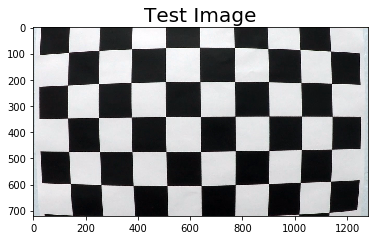

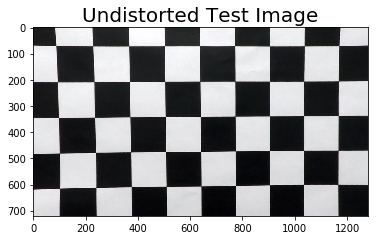

In [10]:
# Test camera calibration on one of the calibration images
img = cv2.imread(fnames[0])

plt.title('Test Image', fontsize=20)
plt.imshow(img)
plt.show()

undist = cv2.undistort(img, mtx, dist, None, mtx)

plt.title('Undistorted Test Image', fontsize=20)
plt.imshow(undist)
plt.show()

## Helper Functions and Classes

In [13]:
# Definition of some helper functions and classes that will be used later

def undistort(img):
    '''
    This function receives a distorted image and returns it undistorted.
    The function assumes, that mtx and dist have been calculated earlier.
    '''
    return cv2.undistort(img, mtx, dist, None, mtx)

## Advanced Lane Detection Pipeline

In [14]:
def pipeline(image):
    image = image.copy()
    # Apply a distortion correction to raw images.
    image = undistort(image)
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    
    # Detect lane pixels and fit to find the lane boundary.
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    
    # Warp the detected lane boundaries back onto the original image.
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    
    return image

## Apply The Pipeline To Test Images

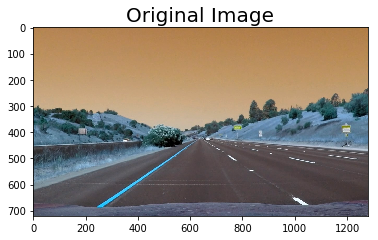

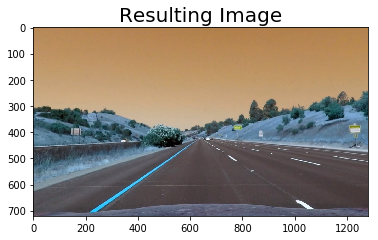

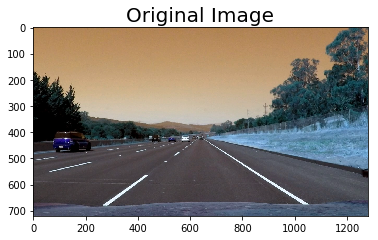

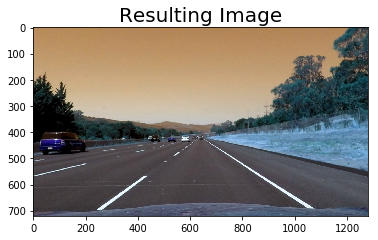

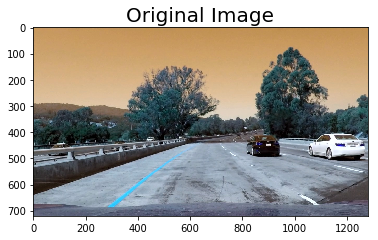

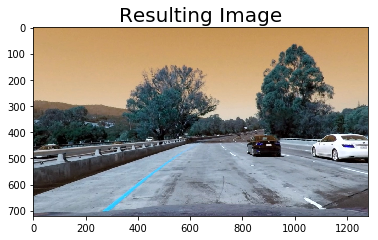

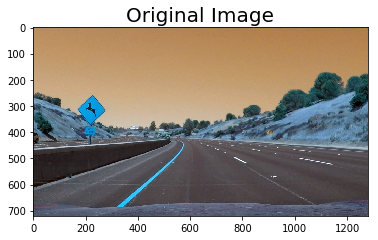

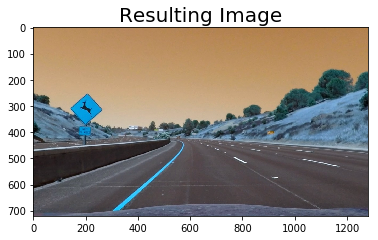

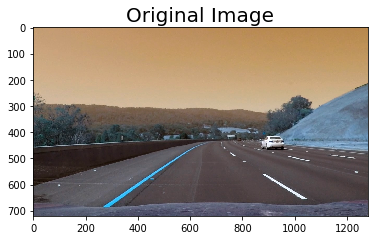

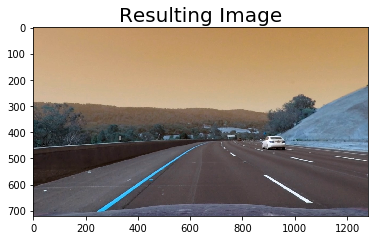

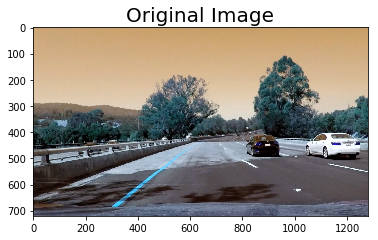

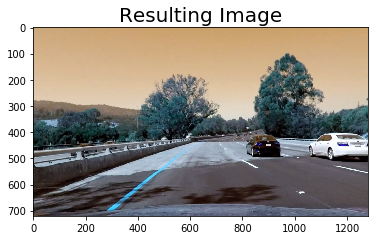

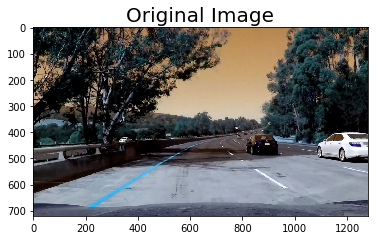

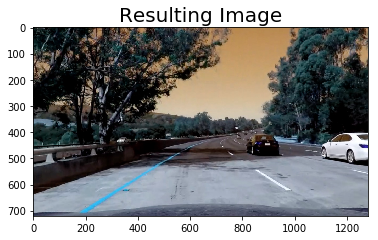

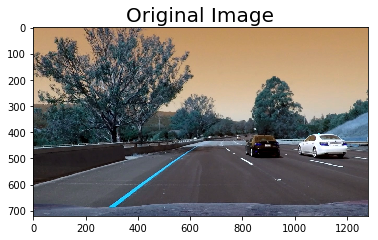

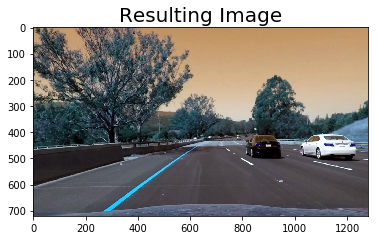

In [16]:
# Make a list of test images
fnames = glob.glob('test_images/*.jpg')

# Iterate trough all test images and apply the pipleline defined above
for fname in fnames:
    img = cv2.imread(fname)
    result_img = pipeline(img)
    plt.title('Original Image', fontsize=20)
    plt.imshow(img)
    plt.show()
    plt.title('Resulting Image', fontsize=20)
    plt.imshow(result_img)
    plt.show()

## Apply The Pipeline To Videos

In [ ]:
#